In [1]:
pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 25.7 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np 
import pandas as pd 
import os
import cv2
import torch
import random
import time  # جديد لإضافة حساب زمن التدريب
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau  # جديد لمعدل التعلم
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix  # جديد للتقييم المفصل
from collections import Counter  # جديد لتحليل توزيع الفئات
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import ViTForImageClassification, ViTImageProcessor, ViTFeatureExtractor
from transformers.modeling_outputs import ImageClassifierOutput


In [3]:
# ======================================
# 1️⃣ تهيئة البيئة وإعدادات التكرارية
# ======================================
def set_seed(seed=42):
    """ضبط كل البذور العشوائية لضمان النتائج قابلة للتكرار"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()  # تطبيق الإعدادات

In [4]:
# ======================================
# 2️⃣ إعداد مسارات البيانات وتحليلها
# ======================================
def analyze_dataset(image_paths, labels):
    """تحليل توزيع البيانات والإحصائيات الأساسية"""
    print("\n📊 Dataset Analysis:")
    print(f"Total samples: {len(image_paths)}")
    print(f"Class distribution: {Counter(labels)}")
    
    # تحليل أحجام الصور
    sizes = []
    for img_path in image_paths[:100]:  # عينة عشوائية لعدم تحميل كل الصور
        img = cv2.imread(img_path)
        if img is not None:
            sizes.append(img.shape)
    
    print("\n📐 Image sizes analysis (sample):")
    print(f"Min size: {min(sizes, key=lambda x: x[0])[0]}x{min(sizes, key=lambda x: x[1])[1]}")
    print(f"Max size: {max(sizes, key=lambda x: x[0])[0]}x{max(sizes, key=lambda x: x[1])[1]}")
    print(f"Average size: {sum(s[0] for s in sizes)//len(sizes)}x{sum(s[1] for s in sizes)//len(sizes)}")

In [5]:
# ======================================
# 3️⃣ فئة Dataset المحسنة
# ======================================
class FootballTacklesDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
        # التحقق من وجود كل الصور
        self.valid_indices = []
        for idx, img_path in enumerate(self.image_paths):
            if os.path.exists(img_path):
                self.valid_indices.append(idx)
            else:
                print(f"⚠️ Warning: Missing image {img_path}")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        img_path = self.image_paths[actual_idx]
        label = self.labels[actual_idx]

        try:
            image = cv2.imread(img_path)
            if image is None:
                raise FileNotFoundError(f"Failed to read image at {img_path}")
                
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            if self.transform:
                augmented = self.transform(image=image)
                image = augmented["image"]
                
            return image, torch.tensor(label, dtype=torch.long)
            
        except Exception as e:
            print(f"Error processing image {img_path}: {str(e)}")
            # إرجاع صورة فارغة وتخطيها لاحقاً في DataLoader
            dummy_image = torch.zeros(3, 224, 224)
            return dummy_image, torch.tensor(-1, dtype=torch.long)  # علامة -1 للبيانات الفاسدة

In [6]:
# ======================================
# 4️⃣ تحسينات زيادة البيانات
# ======================================
def get_transforms():
    train_transform = A.Compose([
        A.Resize(224, 224),
        A.HorizontalFlip(p=0.5),  # الاحتفاظ بالقلب الأفقي فقط
        A.RandomBrightnessContrast(p=0.2),  # تعديل السطوع والتباين
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5),  # الاحتفاظ بالتناوب/التحجيم
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    test_transform = A.Compose([  # لم يتغير
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    
    return train_transform, test_transform

In [7]:
# ======================================
# 5️⃣ تحميل البيانات وتقسيمها
# ======================================
def load_and_split_data(dataset_path, test_size=0.15, val_size=0.15):
    """تحميل البيانات وتقسيمها مع تحسينات"""
    categories = ["Clean_Tackles", "Fouls"]
    image_paths, labels = [], []

    for idx, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        if not os.path.exists(category_path):
            raise FileNotFoundError(f"Category path {category_path} does not exist")
            
        for img_file in os.listdir(category_path):
            full_path = os.path.join(category_path, img_file)
            image_paths.append(full_path)
            labels.append(idx)

    # تحليل البيانات قبل التقسيم
    analyze_dataset(image_paths, labels)
    
    # التقسيم: 70% تدريب، 15% تحقق، 15% اختبار
    train_images, test_images, train_labels, test_labels = train_test_split(
        image_paths, labels, test_size=test_size+val_size, random_state=42, stratify=labels
    )
    
    val_images, test_images, val_labels, test_labels = train_test_split(
        test_images, test_labels, test_size=test_size/(test_size+val_size), random_state=42, stratify=test_labels
    )
    
    return train_images, val_images, test_images, train_labels, val_labels, test_labels

In [8]:
# ======================================
# 6️⃣ إعداد النموذج مع تحسينات
# ======================================
def setup_model(num_classes, device, model_name='resnet50'):
    """إعداد النموذج مع خيارات متعددة"""
    if model_name == 'resnet50' or model_name == 'efficientnet':
        if model_name == 'resnet50':
            model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1) 
        elif model_name == 'efficientnet':
            model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1) 
        else:
            raise ValueError(f"Unknown model {model_name}")
        
        # تجميد الطبقات الأولى
        for param in model.parameters():
            param.requires_grad = False
            
        # تعديل الطبقة الأخيرة
        if model_name == 'resnet50':
            num_ftrs = model.fc.in_features
            model.fc = nn.Sequential(
                nn.Linear(num_ftrs, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, num_classes)
            )
        else:  # efficientnet
            num_ftrs = model.classifier[1].in_features
            model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    else:
       
        model_name = "google/vit-base-patch16-224-in21k"
        
        model = ViTForImageClassification.from_pretrained(
            model_name,
            ignore_mismatched_sizes=True,
            num_labels=num_classes
        )
        
        # تعديل طبقة التصنيف بشكل مباشر
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
            

    model = model.to(device)
    
    # طباعة ملخص النموذج
    print(f"\n🔄 Using {model_name} with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")
    
    return model

In [9]:
# ======================================
# 7️⃣ التدريب مع Early Stopping والتتبع
# ======================================
def train_model(model, loaders, criterion, optimizer, scheduler, num_epochs, device):
    """دالة التدريب المحسنة مع Early Stopping وتتبع الأداء"""
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'lr': []  # جديد لتتبع معدل التعلم
    }
    
    best_val_loss = float('inf')
    best_model_weights = None
    patience = 3
    no_improve = 0
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        # مرحلة التدريب
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in tqdm(loaders['train'], desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
            images, labels = images.to(device), labels.to(device)
            
            # تخطي العينات الفاسدة (التي تحمل علامة -1)
            if (labels == -1).any():
                continue
                
            optimizer.zero_grad()
            outputs = model(images)

            if isinstance(outputs, ImageClassifierOutput):
                outputs = outputs.logits
            else:
                outputs = outputs
                
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        train_loss = running_loss / total
        train_acc = 100 * correct / total
        
        # مرحلة التحقق
        val_loss, val_acc = evaluate_model(model, loaders['val'], criterion, device)
        
        # تحديث معدل التعلم
        if scheduler:
            scheduler.step(val_loss)
            current_lr = optimizer.param_groups[0]['lr']
            history['lr'].append(current_lr)
            print(f"Current Learning Rate: {current_lr:.2e}")

        # حفظ النتائج
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # التحقق من Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            torch.save(best_model_weights, 'best_model.pth')
            no_improve = 0
            print("🔥 Model improved and saved!")
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"🛑 Early stopping at epoch {epoch+1}")
                break
        
        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}% | "
              f"LR: {current_lr:.2e} | Time: {epoch_time:.1f}s")
    
    total_time = time.time() - start_time
    print(f"\n✅ Training completed in {total_time//60:.0f}m {total_time%60:.0f}s")
    
    # تحميل أفضل أوزان النموذج
    model.load_state_dict(best_model_weights)
    
    return model, history

In [10]:
# ======================================
# 8️⃣ التقييم المفصل للنموذج
# ======================================
def evaluate_model(model, loader, criterion, device):
    """تقييم النموذج مع حساب الخسارة والدقة"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            # تخطي العينات الفاسدة
            if (labels == -1).any():
                continue
                
            outputs = model(images)
           
            if isinstance(outputs, ImageClassifierOutput):
                outputs = outputs.logits
            else:
                outputs = outputs
            
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    loss = running_loss / total if total > 0 else 0
    accuracy = 100 * correct / total if total > 0 else 0
    
    return loss, accuracy

def detailed_evaluation(model, loader, device, class_names):
    """تقييم مفصل مع مصفوفة الارتباك والتقرير"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            if (labels == -1).any():
                continue

            
            outputs = model(images)

            if isinstance(outputs, ImageClassifierOutput):
                outputs = outputs.logits
            else:
                outputs = outputs
                
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print("\n📊 Detailed Evaluation:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # مصفوفة الارتباك
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    return all_preds, all_labels

In [11]:
# ======================================
# 9️⃣ تصور نتائج التدريب
# ======================================
def plot_training_history(history):
    """رسم بياني لتاريخ التدريب"""
    plt.figure(figsize=(12, 5))
    
    # رسم الخسارة
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # رسم الدقة
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # رسم معدل التعلم إذا كان موجوداً
    if 'lr' in history:
        plt.figure(figsize=(6, 4))
        plt.plot(history['lr'], label='Learning Rate')
        plt.title('Learning Rate Schedule')
        plt.xlabel('Epoch')
        plt.ylabel('LR')
        plt.legend()
        plt.show()

In [12]:
# ======================================
# 🔟 التنبؤ على صورة واحدة
# ======================================
def predict_single_image(model, image_path, transform, device, class_names):
    """تنبؤ النموذج على صورة واحدة"""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image {image_path} not found")
    
    model.eval()
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to read image {image_path}")
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # تطبيق التحويلات
    augmented = transform(image=image)
    img_tensor = augmented["image"].unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img_tensor)
        if isinstance(output, ImageClassifierOutput):
            output = output.logits
        else:
            output = output
                
        _, predicted = torch.max(output, 1)
        prob = torch.nn.functional.softmax(output, dim=1)
    
    pred_class = class_names[predicted.item()]
    confidence = prob[0][predicted.item()].item()
    
    # عرض الصورة والنتيجة
    plt.imshow(image)
    plt.title(f"Predicted: {pred_class}\nConfidence: {confidence:.2%}")
    plt.axis('off')
    plt.show()
    
    return pred_class, confidence

Using device: cuda

📊 Dataset Analysis:
Total samples: 925
Class distribution: Counter({0: 496, 1: 429})

📐 Image sizes analysis (sample):
Min size: 162x202
Max size: 905x1496
Average size: 668x879


/usr/local/lib/python3.10/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔄 Using google/vit-base-patch16-224-in21k with 85,800,194 trainable parameters
Current LR: 3e-05


Epoch 1/20 - Training: 100%|██████████| 21/21 [00:20<00:00,  1.02it/s]


Current Learning Rate: 3.00e-05
🔥 Model improved and saved!
Epoch 1/20 | Train Loss: 0.6369, Acc: 65.22% | Val Loss: 0.5275, Acc: 81.29% | LR: 3.00e-05 | Time: 22.8s


Epoch 2/20 - Training: 100%|██████████| 21/21 [00:20<00:00,  1.04it/s]


Current Learning Rate: 3.00e-05
🔥 Model improved and saved!
Epoch 2/20 | Train Loss: 0.4888, Acc: 79.60% | Val Loss: 0.3983, Acc: 86.33% | LR: 3.00e-05 | Time: 22.7s


Epoch 3/20 - Training: 100%|██████████| 21/21 [00:21<00:00,  1.01s/it]


Current Learning Rate: 3.00e-05
🔥 Model improved and saved!
Epoch 3/20 | Train Loss: 0.3510, Acc: 87.33% | Val Loss: 0.2956, Acc: 90.65% | LR: 3.00e-05 | Time: 23.9s


Epoch 4/20 - Training: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it]


Current Learning Rate: 3.00e-05
🔥 Model improved and saved!
Epoch 4/20 | Train Loss: 0.2653, Acc: 91.50% | Val Loss: 0.2292, Acc: 94.24% | LR: 3.00e-05 | Time: 25.3s


Epoch 5/20 - Training: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it]


Current Learning Rate: 3.00e-05
🔥 Model improved and saved!
Epoch 5/20 | Train Loss: 0.1683, Acc: 96.75% | Val Loss: 0.2090, Acc: 91.37% | LR: 3.00e-05 | Time: 26.1s


Epoch 6/20 - Training: 100%|██████████| 21/21 [00:22<00:00,  1.06s/it]


Current Learning Rate: 3.00e-05
🔥 Model improved and saved!
Epoch 6/20 | Train Loss: 0.1426, Acc: 95.67% | Val Loss: 0.1854, Acc: 92.81% | LR: 3.00e-05 | Time: 25.0s


Epoch 7/20 - Training: 100%|██████████| 21/21 [00:22<00:00,  1.06s/it]


Current Learning Rate: 3.00e-05
Epoch 7/20 | Train Loss: 0.0841, Acc: 98.45% | Val Loss: 0.2432, Acc: 90.65% | LR: 3.00e-05 | Time: 24.2s


Epoch 8/20 - Training: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it]


Current Learning Rate: 3.00e-05
🔥 Model improved and saved!
Epoch 8/20 | Train Loss: 0.0733, Acc: 98.76% | Val Loss: 0.1579, Acc: 94.24% | LR: 3.00e-05 | Time: 25.4s


Epoch 9/20 - Training: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it]


Current Learning Rate: 3.00e-05
🔥 Model improved and saved!
Epoch 9/20 | Train Loss: 0.0441, Acc: 99.23% | Val Loss: 0.1304, Acc: 96.40% | LR: 3.00e-05 | Time: 25.3s


Epoch 10/20 - Training: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it]


Current Learning Rate: 3.00e-05
Epoch 10/20 | Train Loss: 0.0345, Acc: 99.54% | Val Loss: 0.1889, Acc: 92.81% | LR: 3.00e-05 | Time: 24.5s


Epoch 11/20 - Training: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it]


Current Learning Rate: 3.00e-05
Epoch 11/20 | Train Loss: 0.0487, Acc: 98.92% | Val Loss: 0.3500, Acc: 83.45% | LR: 3.00e-05 | Time: 24.5s


Epoch 12/20 - Training: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it]


Current Learning Rate: 3.00e-06
🛑 Early stopping at epoch 12

✅ Training completed in 4m 54s


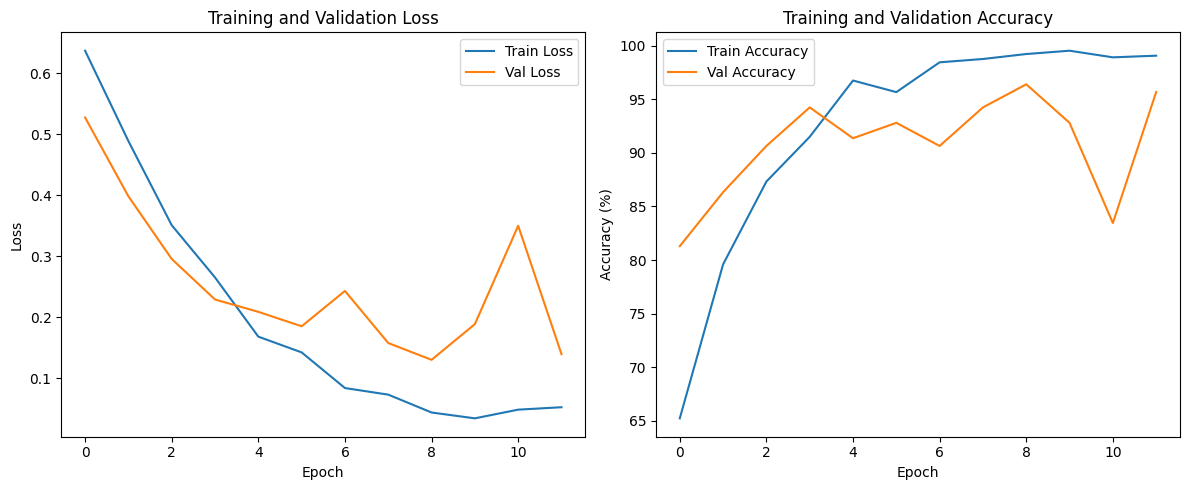

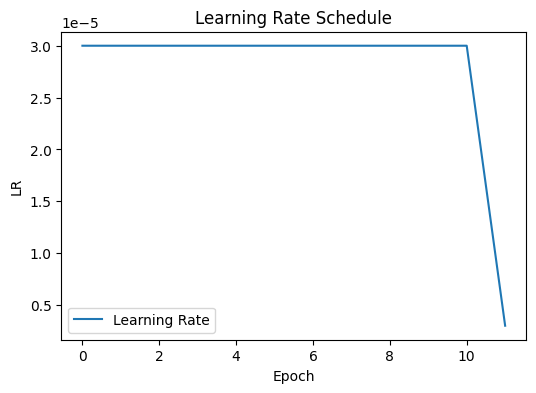


🧪 Test Results - Loss: 0.3002, Accuracy: 89.21%

📊 Detailed Evaluation:
               precision    recall  f1-score   support

Clean_Tackles       0.89      0.91      0.90        75
        Fouls       0.89      0.88      0.88        64

     accuracy                           0.89       139
    macro avg       0.89      0.89      0.89       139
 weighted avg       0.89      0.89      0.89       139



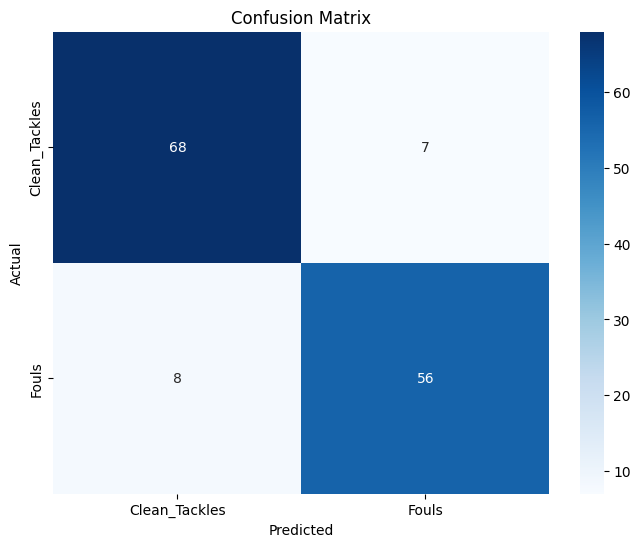

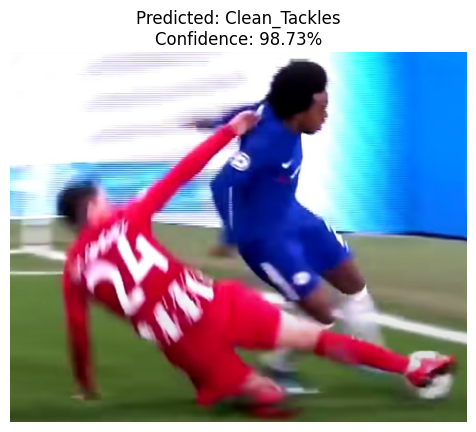


🔍 Sample Prediction: Clean_Tackles with 98.73% confidence


In [13]:
# ======================================
# 🏁 التنفيذ الرئيسي
# ======================================
if __name__ == "__main__":
    # 1. إعداد الجهاز
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # 2. تحميل وتقسيم البيانات
    dataset_path = "/kaggle/input/football-tackles/var500/VAR"  # تغيير حسب الحاجة
    train_images, val_images, test_images, train_labels, val_labels, test_labels = load_and_split_data(dataset_path)
    
    # 3. إعداد التحويلات ومحملات البيانات
    train_transform, test_transform = get_transforms()
    
    train_dataset = FootballTacklesDataset(train_images, train_labels, train_transform)
    val_dataset = FootballTacklesDataset(val_images, val_labels, test_transform)
    test_dataset = FootballTacklesDataset(test_images, test_labels, test_transform)
    
    loaders = {
        'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2),
        'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2),
        'test': DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
    }
    
    # 4. إعداد النموذج
    class_names = ["Clean_Tackles", "Fouls"]
    model = setup_model(len(class_names), device, model_name='ViT')
    
    # 5. إعداد الخسارة والمحسن
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=3e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current LR: {optimizer.param_groups[0]['lr']}")
    
    # 6. التدريب
    model, history = train_model(
        model, loaders, criterion, optimizer, scheduler, 
        num_epochs=20, device=device
    )
    
    # 7. تصور نتائج التدريب
    plot_training_history(history)
    
    # 8. التقييم على مجموعة الاختبار
    test_loss, test_acc = evaluate_model(model, loaders['test'], criterion, device)
    print(f"\n🧪 Test Results - Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")
    
    # 9. التقييم المفصل
    detailed_evaluation(model, loaders['test'], device, class_names)
    
    # 10. اختبار على صورة واحدة كمثال
    sample_image = test_images[0]  # أول صورة في مجموعة الاختبار
    pred_class, confidence = predict_single_image(
        model, sample_image, test_transform, device, class_names
    )
    print(f"\n🔍 Sample Prediction: {pred_class} with {confidence:.2%} confidence")

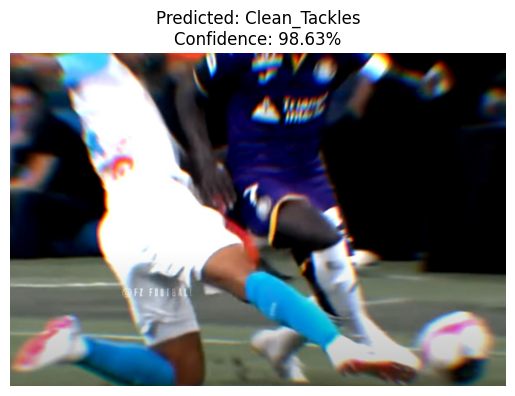


🔍 Sample Prediction: Clean_Tackles with 98.63% confidence


In [14]:
# 10. اختبار على صورة واحدة كمثال
sample_image = test_images[29]  # أول صورة في مجموعة الاختبار
pred_class, confidence = predict_single_image(
    model, sample_image, test_transform, device, class_names
)
print(f"\n🔍 Sample Prediction: {pred_class} with {confidence:.2%} confidence")

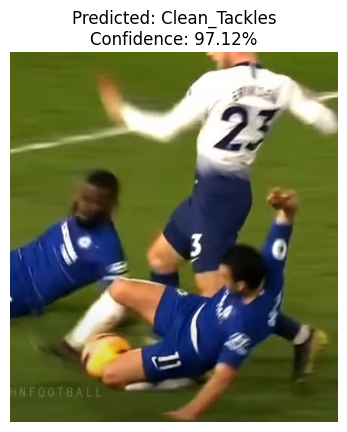


🔍 Sample Prediction: Clean_Tackles with 97.12% confidence


In [15]:
sample_image = test_images[22] 
pred_class, confidence = predict_single_image(
    model, sample_image, test_transform, device, class_names
)
print(f"\n🔍 Sample Prediction: {pred_class} with {confidence:.2%} confidence")

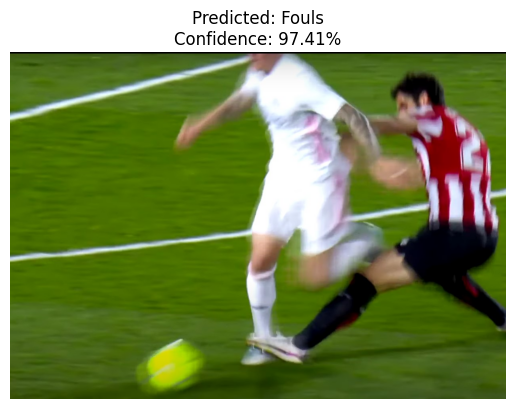


🔍 Sample Prediction: Fouls with 97.41% confidence


In [16]:
sample_image = test_images[50] 
pred_class, confidence = predict_single_image(
    model, sample_image, test_transform, device, class_names
)
print(f"\n🔍 Sample Prediction: {pred_class} with {confidence:.2%} confidence")